# Assignment 4

In this assignment, you'll combine the assignment 3 data set with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list). The CSV file `fresh.csv` contains the fresh fruits and vegetables data you extracted in assignment 3.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . You need a key in order to use the API. Only 1000 requests are allowed per hour, so it would be a good idea to use [caching][requests_cache].

[Sign up for an API key here](https://api.data.gov/signup/). The key will work with any Data.gov API. You may need the key again later in the quarter, so make sure you save it.

These modules may be useful:

* [requests](http://docs.python-requests.org/en/master/user/quickstart/)
* [requests_cache][]
* [urlparse](https://docs.python.org/2/library/urlparse.html)
* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

[requests_cache]: https://pypi.python.org/pypi/requests-cache

__Exercise 1.1.__ Read the [search request documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-SEARCH.md), then write a function called `ndb_search()` that makes a search request. The function should accept the search term as an argument. The function should return the search result items as a list (for 0 items, return an empty list).

Note that the search url is: `https://api.nal.usda.gov/ndb/search`

As an example, a search for `"quail eggs"` should return this list:

```python
[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]
```

As usual, make sure you document and test your function.

In [1]:
#Import key packages that are necessary for getting the data, and also specify the API key
from fastcache import clru_cache
import requests
import numpy as np
import re
import pandas as pd

key="oM6WlXjshsT7qoF14z0I3qiKe3tK7bo9tgD8uUol"

__Solution to 1.1: A function for extracting queries is written__

In [3]:
#Create a search function that performs queries on the food database, also set up a "function cache"
#Reason why I am using a function cache instead of a query cache: other compatible packages (i.e. CacheControl) didn't work
#The cache works by caching functions by input
@clru_cache(maxsize=128,typed=False)
def ndb_search(search_term,group=""):
    """
    ndb_search: do a query upon the USDA food database.
    INPUT:
    search_term (chr): the term to search
    group (chr): the group query to specify (usually for getting raw fruits or raw vegetables)
    OUTPUT:
    search_json (list): a list with each query item
    """
    search="https://api.nal.usda.gov/ndb/search/?format=json&q="+search_term
    search=search+"&sort=r&offset="+"&api_key="+key+"&ds=Standard Reference"+group
    search_request=requests.get(search)
    search_json=search_request.json()
    try:
        search_list=search_json["list"]["item"]
    except KeyError:
        search_list=[]
    return(search_list)

__Exercise 1.2.__ Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* You can convert the output of `ndb_search()` to a data frame with `pd.DataFrame()`.
* The string methods for [Python](https://docs.python.org/2/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/text.html#method-summary) are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

In [4]:
#Start by importing the fresh data frame
fresh=pd.read_csv("fresh.csv")
fresh.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit


In [7]:
#Key function for extracting ndb numbers.
def getNdb(food,foodtype,foodform):
    """
    getNdb: Extract NDB numbers from the food database using my data strategy (explained after the solution to 1.2)
    INPUT:
    food (chr): The food name, coming from the fresh dataframe's 'food' variable
    foodtype (chr): The food type, coming from the fresh dataframe's 'type' variable
    foodform (chr): The food form, coming from the fresh dataframe's 'form' variable
    OUTPUT:
    food_query/food_match (chr): The corresponding NDB number extracted from either the 'match method' or 'query method'.
    """
    #Part I of the function: Attempt the 'match method', which uses regular expressions
    if foodtype=="fruit":
        group_name="&fg=Fruits and Fruit Juices"
    else:
        group_name="&fg=Vegetables and Vegetable Products"
    #Query either raw fruits or vegetables
    food_list=ndb_search("raw",group=group_name)
    #In order to get special cases from the form variable, i.e. cucumbers/cabbages, we have to do a little bit of hard-coding
    food_form_fix=re.sub("(Fresh|"+food+"|[0-9,]|consumed | green)","",foodform)
    #Generate the proper regular expression
    food_regex=re.sub(" ",".*",food+food_form_fix)
    #Perform the method
    food_match=[item for item in food_list if bool(re.search(food_regex,item["name"],re.IGNORECASE)) == True]
    if len(food_match)==0:
        #If the method fails, do the 'query method' on the database with the food name instead of just looking at all raw foods
        food_search=" ".join(food.split("_"))+food_form_fix+" raw"
        food_query=ndb_search(food_search)
        return(food_query[0]["ndbno"])
    else:
        return(food_match[0]["ndbno"])

In [10]:
#Use a generator expression to get the numbers, also use *tuple to iterate over columns of fresh
the_ndbs=[getNdb(*tuple(row[["food","type","form"]])) for index, row in fresh.iterrows()]

__Solution 1.2: The ndb numbers are now attached to the dataframe.__

In [9]:
#Append the ndb numbers to the dataframe
ndb_col=pd.DataFrame({"ndb":pd.Series(the_ndbs)},index=fresh.index)
fresh_ndb=pd.concat([fresh,ndb_col],axis=1)
fresh_ndb.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,ndb
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit,09326
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit,09181
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit,09218
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit,09316
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit,09279


__Data Strategy:__ For 1.2, I decided to use a two-pronged strategy. The first strategy I used was the **match method**, in which I queried raw fruits or raw vegetables, and matched a pattern to the name strings. I allow myself to repeat the same query because the function call is cached after the first time, hence running the generator expression only calls the API once. The generator expression returns the item, and the return call at the end extracts the NDB number. 

The second strategy I used is the **query method** in case the regular expression returned no results. I performed these strategies in the given order because the **match method** was guaranteed to be more precise, due to the robustness of the regular expression. The query method can be less precise, especially in the case of "kiwi". Nonetheless, the query method works all times it is called when I use it.

**I was able to retrieve all of the NDB numbers, if you want to see, you can unhash the code below**

In [13]:
#fresh_ndb.loc[:,["food","ndb"]]

__Exercise 1.3.__ Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}
```

Be sure to document and test your function.

In [18]:
def getFoodReport(ndbno):
    """
    getFoodReport: Do a query on the food reports API
    INPUT:
    ndbno (chr): The corresponding NDB number for the food item
    OUTPUT:
    nutrients_list (list): A list of nutrients for the corresponding food item
    """
    search="https://api.nal.usda.gov/ndb/V2/reports?ndbno="+ndbno+"&type=f&format=json&api_key="+key
    search_request=requests.get(search)
    search_json=search_request.json()
    #Extract the nutrients from the JSON dictionary, I had to do a little bit of eyeballing and searching here
    nutrients_list=search_json["foods"][0]["food"]["nutrients"]
    return(nutrients_list)

In [21]:
#Iterrate by row of the dataframe, I assign index so the expression can access rows easier
food_reports=[getFoodReport(row["ndb"]) for index,row in fresh_ndb.iterrows()]

In [22]:
#I wrote a function to extract a variable from the food reports
def getNutrition(name,criteria):
    """
    getNutrition: Extract a variable from each food report and make it into an array with type float
    INPUT:
    name (chr): The variable name to match from the list of nutrients
    criteria (chr): The criteria to match on, usually either names or units.
    OUTPUT:
    nut_fix (ndarray): An array that contains values of the extracted variable, in float form. NaN is returned if no match."""
    nut=np.array([[indiv_report["value"] for indiv_report in all_reports if indiv_report[criteria]==name] for all_reports in food_reports])
    #Fix the data. The data is extracted in list form, if the list is empty return NaN.
    nut_fix=np.array(list(map(lambda x: np.nan if x==[] else x[0], nut))).flatten()
    return(nut_fix)

__Solution to 1.3__: Add the selected nutrition variables extracted from food reports to the data frame.

In [23]:
#I decided to hard code the variables I wanted to extract, and then used a tuple method to iterate it over the function
names_to_get=[["Protein","Fiber, total dietary","Vitamin C, total ascorbic acid","Vitamin A, RAE",
               "Total lipid (fat)","Sugars, total","Sodium, Na","kcal"],["name"]*7+["unit"],
              ["protein","fiber","vitamin_c","vitamin_a","fat","sugar","sodium","calories"]]
names_matrix=np.array(names_to_get).T.reshape(8,3)
nut_data_matrix=np.array([getNutrition(*tuple(nm[0:2])) for nm in names_matrix])
#This result yielded a data matrix, which I then reshaped and made into a data frame. The final result was concatenated to fresh.
nutrition_df=pd.DataFrame(nut_data_matrix.T.reshape(49,8),columns=names_matrix[:,2])
fresh_nut_df=pd.concat([fresh_ndb,nutrition_df],axis=1)
fresh_nut_df.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,ndb,protein,fiber,vitamin_c,vitamin_a,fat,sugar,sodium,calories
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit,09326,0.61,0.4,8.1,28.0,0.15,6.20,1.0,30.0
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit,09181,0.84,0.9,36.7,169.0,0.19,7.86,16.0,34.0
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit,09218,0.81,1.8,26.7,34.0,0.31,10.58,2.0,53.0
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit,09316,0.67,2.0,58.8,1.0,0.30,4.89,1.0,32.0
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit,09279,0.70,1.4,9.5,17.0,0.28,9.92,0.0,46.0


__Exercise 1.4.__ Which foods provide the best combination of price, yield, and nutrition? You can use kilocalories as a measure of "nutrition" here, but more a detailed analysis is better. Use plots to support your analysis.

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 7.0)
from pandas.tools.plotting import scatter_matrix

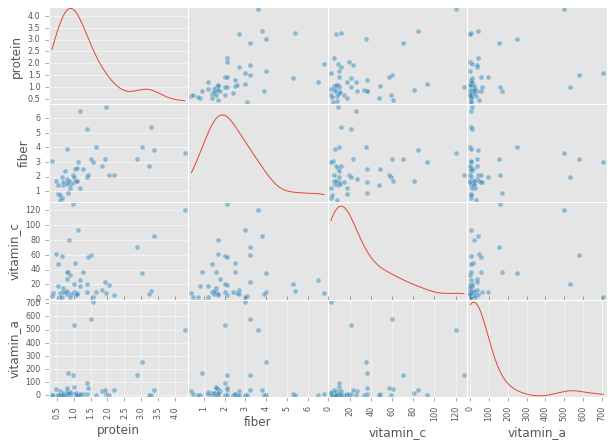

In [26]:
#Plot the 'good' nutrition variables, what are their relationships?
scatter_matrix(fresh_nut_df.iloc[:,8:12], diagonal='kde',s=100)
plt.show()

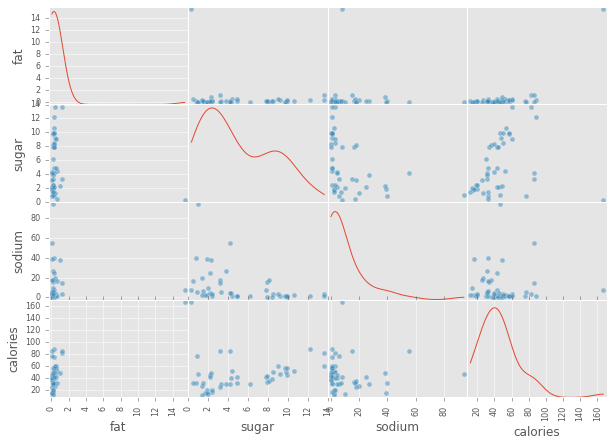

In [27]:
#Plot the 'bad' nutrition variables, what are their relationships?
scatter_matrix(fresh_nut_df.iloc[:,12:], diagonal='kde',s=100)
plt.show()

__Strategy for 1.4:__ After examining these variables, I decided to use **Mahalanobi's Distance** on my data. I wanted to find the "best" combinations of these variables, but I also wanted to account for covariance between the variables. I did this based on some facts I had about the data, such as all 8 of the nutrition variables having support $\Bbb R_+$. I wanted to generate a metric that positively weighted "good" nutrtion variables, and negatively weighted "bad" ones. The issue I had is that Mahalanobi's distance is non-negative, so it wouldn't take in the negative effects of the bad variables. I decided to compute split the data matrices by the variable being good or bad and then calculated the respective metrics $D_m(X)$ and $D_m(Y)$. $D_m(X)$ is defined as the **nutrition score**, $D_m(Y)$ is defined as the **malnutrition score** and $D_m(X)-D_m(Y)$ is the difference between these two.

After doing this, I examined the **price_per_lb** and **yield** variables compared with the difference in nutrition scores. I decided to standardize the three variables, and take the sum of them, this ended up being my **final score** for the variables. The results can be seen at the end of the problem.

In [28]:
from sklearn.preprocessing import Imputer
from scipy.spatial.distance import mahalanobis

In [41]:
#Split the data matrix into two components, variables that are "nutritious" and "malnutritious"
goodnut_data_matrix=nut_data_matrix[0:4,:]
badnut_data_matrix=nut_data_matrix[5:,:]

In [42]:
def apply_mahalanobis(data_matrix):
    """
    apply_mahalanobis: Get the Mahalanobi's distance for a data matrix.
    INPUT:
    data_matrix (2D ndarray): An n x p data matrix with continuous variables.
    OUTPUT:
    mah_dist (list): An n x 1 vector in list form with the Mahalanobi's distance for each entry."""
    #I had to use an imputing strategy on the data due to missing values.
    #I decided to use median because most of the data distributions appeared to be skewed.
    data_impute=Imputer(missing_values="NaN",strategy="median")
    data_impute.fit(data_matrix)
    data_matrix_na_free=data_impute.transform(data_matrix)
    cov_matrix=np.cov(data_matrix_na_free.T)
    inv_cov=np.linalg.inv(cov_matrix)
    #I wanted to make the distance "scored" by 0 having the worst score, so I used zeroes instead of a mean vector.
    mah_dist=[mahalanobis(u=dm,v=np.zeros(cov_matrix.shape[0]),VI=inv_cov) for dm in data_matrix_na_free]
    return(mah_dist)

In [43]:
#Generate the nutrtion/malnutrition scores and the difference, concatenate these to the original dataframe.
nut_score=apply_mahalanobis(goodnut_data_matrix.T)
malnut_score=apply_mahalanobis(badnut_data_matrix.T)
score_diff=np.array(nut_score)-np.array(malnut_score)
both_scores=pd.DataFrame(np.array([nut_score,malnut_score,score_diff]).T.reshape(49,3),columns=["nut_score","malnut_score","score_diff"])
fresh_scored=pd.concat([fresh,both_scores],axis=1)
fresh_scored.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,nut_score,malnut_score,score_diff
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit,0.698273,1.982441,-1.284168
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit,1.513979,2.908572,-1.394592
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit,1.491704,3.415853,-1.924150
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit,2.386033,1.715399,0.670634
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit,1.060592,3.111046,-2.050454


We have now gone full circle. We're at the end of assignment 3 again, but now we have our nutritional information, simplified.

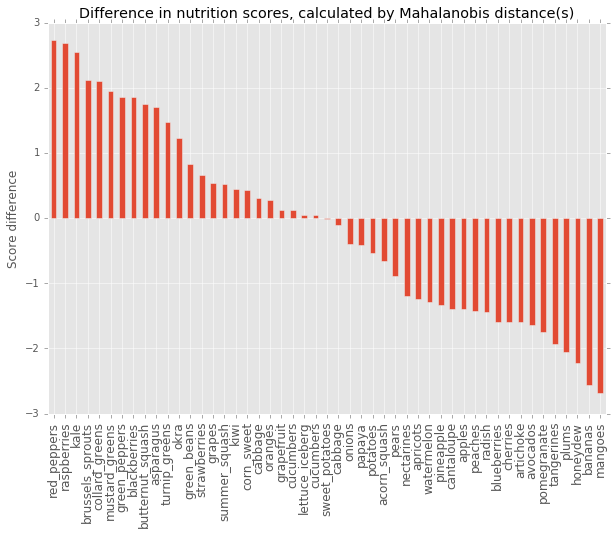

In [48]:
#Make a barplot to see what variables do the best under our nutrition score metric.
sort_score1=fresh_scored.sort_values(by="score_diff",ascending=False)
sort_score1.score_diff.plot(kind="bar")
plt.xticks(fresh.index, sort_score1.food, rotation=90, fontsize = 12)
plt.ylabel("Score difference")
plt.title("Difference in nutrition scores, calculated by Mahalanobis distance(s)")
plt.show()

We can observe that the best scores tend to come from vegetables, except for the case of raspberries. Now that we know how the nutrition metric works, let's examine its relationship between yield and price.

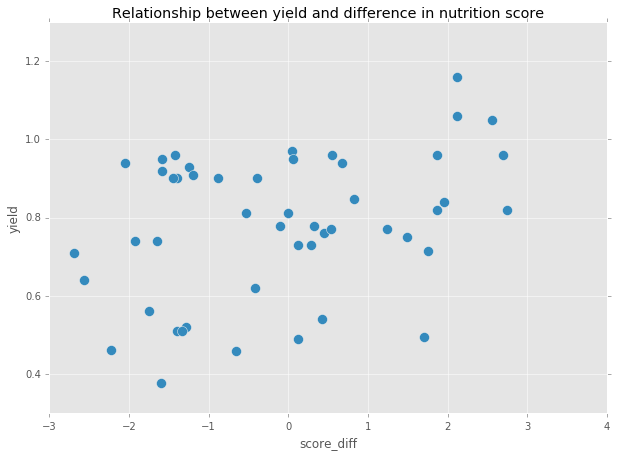

In [52]:
fresh_scored.plot(x="score_diff",y="yield",kind="scatter",s=100)
plt.xlabel("difference in nutrition score")
plt.title("Relationship between yield and difference in nutrition score")
plt.show()

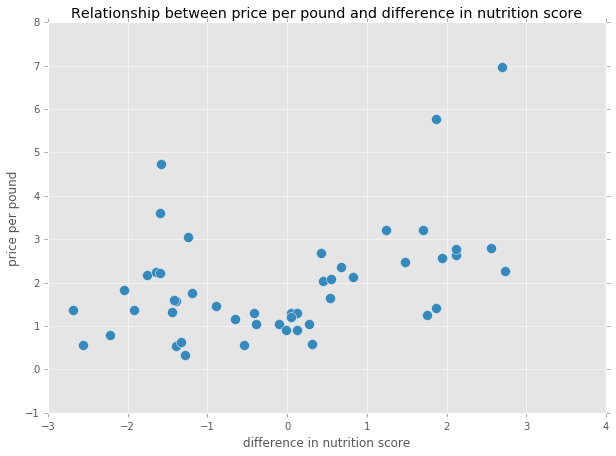

In [53]:
fresh_scored.plot(x="score_diff",y="price_per_lb",kind="scatter",s=100)
plt.xlabel("difference in nutrition score")
plt.ylabel("price per pound")
plt.title("Relationship between price per pound and difference in nutrition score")
plt.show()

This brings us to our final step of the problem, we have to reduce these three variables into one score. I decided to get a linear combination of the three variables. In order to prevent any one of the variables from influencing the score too much, I standardized all of them. I also wanted to make sure having a lower price caused a higher score, so I made it negative.

In [54]:
#Reverse prices
price_neg=-fresh_scored.price_per_lb
#Create a data matrix with nutrition, price and yield (I cannot extract yield by name due to how it is named)
best_combo_dm=np.array([fresh_scored.score_diff,price_neg,fresh_scored.iloc[:,2]]).T.reshape(49,3)
#Standardize all the variables
best_combo_std=(best_combo_dm-np.mean(best_combo_dm,axis=0))/np.std(best_combo_dm,axis=0)
final_score=np.sum(best_combo_std,axis=1)
#Finally, concatenate the food name to its corresponding score
combo_df=pd.concat([fresh.food,pd.DataFrame(final_score,columns=["final_score"])],axis=1)

__Solution to 1.4: Show the top 5 foods that have the best combination__

In [55]:
#Which foods are the best combo?
combo_df.sort_values(by="final_score",ascending=False).head()

,food,final_score
32,collard_greens,3.040470
43,kale,2.593807
47,brussels_sprouts,2.390860
46,green_peppers,1.952014
35,red_peppers,1.863166


Based off of my metric, collard greens is the food that has the best combination of price, yield and nutrition. It seems that vegetables tend to perform better because they are generally more nutritious than fruits.